In [109]:
import networkx
import matplotlib.pyplot as plt
import random
from num2words import num2words


def generate_weighted_ring_cluster(num_nodes):
    if num_nodes <= 2:
        raise ValueError("num_nodes mush > 2")
    g = networkx.cycle_graph(num_nodes)
    for edge in g.edges:
        g.edges[edge]['weight'] = round(random.uniform(0.6, 1),1)
        
        
    return g
    
def generate_complete_cluster(num_nodes):
    if num_nodes <= 3:
        raise ValueError("num_nodes mush > 3")
    g = networkx.complete_graph(num_nodes)
    for edge in g.edges:
        g.edges[edge]['weight'] = round(random.uniform(0.6, 1),1)
        
    return g   


def generate_full_rary_tree_cluster(num_nodes):
    if num_nodes <= 3:
        raise ValueError("num_nodes mush > 3")
    g = networkx.full_rary_tree(4,num_nodes)
    for edge in g.edges:
        g.edges[edge]['weight'] = round(random.uniform(0.7, 1),1)
        
    return g  

g = generate_full_rary_tree_cluster(5)
    
def generate_graph(cluster_sizes = [4], ring_sizes = [3], weak_connected = False):
      
    clusters = []
    for num in cluster_sizes:
        clusters.append(generate_full_rary_tree_cluster(num))
        
    for num in ring_sizes:
        clusters.append(generate_weighted_ring_cluster(num))
        
    
    random.shuffle(clusters)
    
    names = []
    for i in range(len(clusters)):
        names.append(str(i) + "_")
    
    g = networkx.union_all(clusters, rename=names)
    if weak_connected:
        for i in range(len(clusters)-1):
            g.add_edge(str(i) + "_1", str(i+1) + "_2", weight = round(random.uniform(0.1, 0.3),1))
     
    list_of_numbers = list(range(0, g.number_of_nodes()))
    random.shuffle(list_of_numbers)
    node_names = list(g.nodes())
    mapping = dict()
    i = 0
    for name in node_names:
        mapping[name] = "N_" + str(list_of_numbers[i])
        i += 1

    ramed_graph = networkx.relabel_nodes(g, mapping)
            
    return ramed_graph


def draw_graph(G):
    plt.figure(figsize=(10, 10))
    pos=networkx.spring_layout(G)
    networkx.draw_networkx(G,pos)
    labels = networkx.get_edge_attributes(G,'weight')
    #nx.draw(G, pos, with_labels=True, node_color='cyan', font_size=10, font_weight='bold', node_size=800)
    networkx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()

def get_sample(cluster_sizes = [4], ring_sizes = [3], weak_connected = False, draw = False):
    g = generate_graph(cluster_sizes, ring_sizes, weak_connected)
    if draw == True:
        draw_graph(g)
    sample = dict()
    edges_str = []
    for u, v, data in g.edges(data=True):
        weight = data['weight']
        edge = f" [{u}$${v}: {weight}]"
        edges_str.append(edge)
        
    sample['edges'] = edges_str
    sample['node_num'] = g.number_of_nodes()
    sample['cluster_num'] = len(cluster_sizes)+len(ring_sizes)
    sample['ring_num'] = len(ring_sizes)
    if networkx.has_path(g, source="N_0", target="N_"+str(g.number_of_nodes()-1)):
        #dijkstra
        all_path = []
        for p in networkx.all_shortest_paths(g, source="N_0", target="N_"+str(g.number_of_nodes()-1)):
            all_path.append(p)
        sample['shortest_path_btw_maxnode_minnode'] = all_path
    else:
        sample['shortest_path_btw_maxnode_minnode'] = []
    return sample


In [119]:



def create_chat_sample(graph_sample, question, sys_msg):
    input_text = f"Infer on the graph, N_n means the nth node in the given graph, graph edge is in [N_n1$$N_n2: weight_value] format.\n"
    
    for edge in graph_sample['edges']:
        input_text += edge
        input_text += '\n'
        
    if question == "cluster_number":
        input_text += 'Q:\n Nodes interconnected with edge weight > 0.5 should be grouped in one cluster. How many clusters are in the given graph?\n'
    if question == "ring_number":
        input_text += 'Q:\n how many rings are in the given graph?\n'
    if question == "shortest_path":
        end_path_idx = graph_sample['node_num']-1
        input_text += f'Q:\n print the shotest path from N_0 to N_{end_path_idx} in N_start, N_n1, N_n2,... N_end form? If there is no path, return None\n'
     
    input_text += "A:\n"
        
        
        
    input_str =  [
        {"role": "system", "content": sys_msg}, 
        {"role": "user", "content": input_text}
    ]
    
    if question == "cluster_number":
        ideal_str = [str(graph_sample['cluster_num']) + " clusters", 
                     str(graph_sample['cluster_num']) + " cluster",
                     num2words(graph_sample['cluster_num']) +  " clusters",
                     num2words(graph_sample['cluster_num']) +  " cluster"]
    
    if question == "ring_number":
        if graph_sample['ring_num'] > 0:
            ideal_str = [str(graph_sample['ring_num']) + " rings", 
                         str(graph_sample['ring_num']) + " ring",
                         num2words(graph_sample['ring_num']) +  " rings",
                         num2words(graph_sample['ring_num']) +  " rings"]
        else:
            ideal_str = ["0 rings", "0 ring", "no ring","zero", "none"]
            
    if question == "shortest_path":
        if len(graph_sample['shortest_path_btw_maxnode_minnode']) > 0:
            ideal_str = []
            for path in graph_sample['shortest_path_btw_maxnode_minnode']:
                str1 = ''
                for node in path:
                    str1 += node
                    str1 += ", "
                ideal_str.append(str1[:-2])

                str2 = ''
                for node in path:
                    str2 += node
                    str2 += " "
                ideal_str.append(str2[:-1])
                str3 = ''
                for node in path:
                    str3 += node
                    str3 += " -> "
                ideal_str.append(str3[:-4])
        else:
            ideal_str = ["None","no path", "none", 'no']
        
    
    
    return input_str, ideal_str

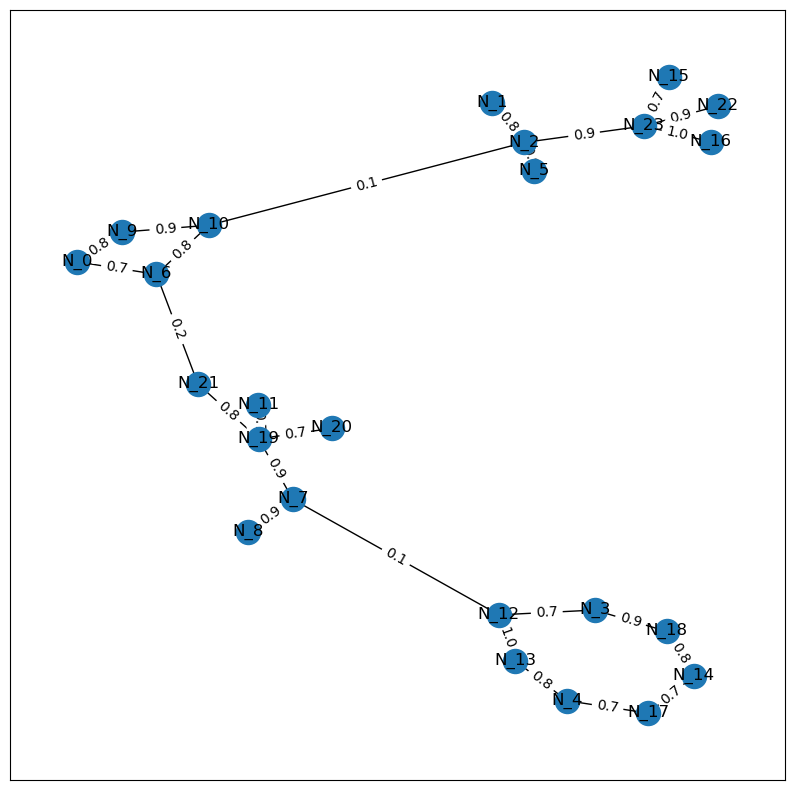

Do not print intermedia steps.
Infer on the graph, N_n means the nth node in the given graph, graph edge is in [N_n1$$N_n2: weight_value] format.
 [N_23$$N_2: 0.9]
 [N_23$$N_22: 0.9]
 [N_23$$N_16: 1.0]
 [N_23$$N_15: 0.7]
 [N_2$$N_5: 0.9]
 [N_2$$N_1: 0.8]
 [N_2$$N_10: 0.1]
 [N_0$$N_6: 0.7]
 [N_0$$N_9: 0.8]
 [N_6$$N_10: 0.8]
 [N_6$$N_21: 0.2]
 [N_10$$N_9: 0.9]
 [N_19$$N_7: 0.9]
 [N_19$$N_21: 0.8]
 [N_19$$N_11: 0.7]
 [N_19$$N_20: 0.7]
 [N_7$$N_8: 0.9]
 [N_7$$N_12: 0.1]
 [N_18$$N_3: 0.9]
 [N_18$$N_14: 0.8]
 [N_3$$N_12: 0.7]
 [N_12$$N_13: 1.0]
 [N_13$$N_4: 0.8]
 [N_4$$N_17: 0.7]
 [N_17$$N_14: 0.7]
Q:
 print the shotest path from N_0 to N_23 in N_start, N_n1, N_n2,... N_end form? If there is no path, return None
A:

N_0, N_6, N_10, N_2, N_23
N_0 N_6 N_10 N_2 N_23
N_0 -> N_6 -> N_10 -> N_2 -> N_23
N_0, N_9, N_10, N_2, N_23
N_0 N_9 N_10 N_2 N_23
N_0 -> N_9 -> N_10 -> N_2 -> N_23


In [131]:
ring_num = 2
non_ring_cluster_num = 2
cluster_max_node = 7
random_list_rings = [random.randint(3, cluster_max_node) for _ in range(ring_num)]
random_list_nr_clusters = [random.randint(4, cluster_max_node) for _ in range(non_ring_cluster_num)]
g = get_sample(random_list_nr_clusters,random_list_rings, True,True)

#Do not print intermedia steps. | Think step by step.
#cluster_number ring_number shortest_path
input_str, ideal_str = create_chat_sample(g,"shortest_path", "Do not print intermedia steps.")
for elem in input_str:
    print(elem['content'])

for elem in ideal_str:
    print(elem)



In [126]:
import pandas as pd


def add_samples(ring_num, non_ring_cluster_num, cluster_max_node, weak_connected, sys_msg):
    if cluster_max_node <= 4:
        raise ValueError("num_nodes mush > 4")
        
    if ring_num == 0 and non_ring_cluster_num ==0:
        return [], []
    
    input_list = []
    ideal_list = []
    
    for q in ['cluster_number', 'ring_number', 'shortest_path']:
                random_list_rings = [random.randint(3, cluster_max_node) for _ in range(ring_num)]
                random_list_nr_clusters = [random.randint(4, cluster_max_node) for _ in range(non_ring_cluster_num)]
                g = get_sample(random_list_nr_clusters, random_list_rings, weak_connected)
                input_str, ideal_str = create_chat_sample(g, q, sys_msg)
                input_list.append(input_str)
                ideal_list.append(ideal_str)
            
    return input_list, ideal_list

                                       
def generate_data_set(max_ring, max_non_ring_cluster, cluster_max_node, size_multiplier ,sys_msg):
    merged_input_list = []
    merged_ideal_list = []
    for size in range(size_multiplier):
        for i in range(max_ring):
            for j in range(max_non_ring_cluster):
                input_list, ideal_list = add_samples(i, j, cluster_max_node, False, sys_msg)
                merged_input_list.extend(input_list)
                merged_ideal_list.extend(ideal_list)  
        for i in range(max_ring):
            for j in range(max_non_ring_cluster):
                input_list, ideal_list = add_samples(i, j, cluster_max_node, True, sys_msg)
                merged_input_list.extend(input_list)
                merged_ideal_list.extend(ideal_list) 
                                       
    data = {'input': merged_input_list, 'ideal': merged_ideal_list}
    df = pd.DataFrame(data)
    
    return df



In [136]:
df = generate_data_set(max_ring = 7, max_non_ring_cluster = 7,cluster_max_node = 7,
                       size_multiplier = 3,
                       sys_msg = "Do not print intermediate steps")
print(len(df))

864


In [137]:
#comprehensive-graph-reasoning

df[["input", "ideal"]].to_json("./samples.jsonl", lines=True, orient="records")